# Analýza VAERS dat
## Úvodem
**Toto není studie, ale pouze analýza dat bez jakéhokoli zaměření.**

Zdrojová data jsou veřejně dostupná, viz. [VAERS](https://vaers.hhs.gov/data/datasets.html).

Zdrojový kód zpracování dat je také veřejně dostupný, viz. [GitHub](https://github.com/fykcz/vaers.git).

Data jsou v souborech pro jednotlivé roky, evidence začíná rokem 1990. Název souboru je tvořen letopočtem a názvem dat: `YYYYVAERSDATA.csv`, resp. `YYYYVAERSVAX.csv`.
Popis struktur souborů a jejich obsahů je na stránce VAERS. Data v těchto souborech jsou svázána přes identifikátor `VAERS_ID`, kde primární data jsou v souboru `VAERSDATA`,
rozšiřující jsou v `VAERSVAX`.

Data nebyla konzultována z žádnou medicínskou autoritou, jedná se čistě o technické zpracování dat, jejich analýzu a vizualizaci s upozorněním na anomálie.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#import pandas as pd
import polars as pl
import os
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import tabulate as tab

In [2]:
# nactu data z mezisouboru
bigdata = pl.read_parquet('bigdata.parquet')
disease_by_vax = pl.read_parquet('disease_by_vax.parquet')
vaxes = pl.read_parquet('vaxes.parquet')

In [3]:
# pocet pripadu na jednotlivy typ vakciny
# odfiltruji COVID19, UNK (unknown) typy a pak vsechny typy, kde je vyskyt mensi nez 1000
vaxcounts = vaxes.lazy().filter(
    (pl.col('VAX_TYPE') != 'COVID19') &
    (pl.col('VAX_TYPE') != 'UNK')).groupby('VAX_TYPE').agg(pl.count().alias('Count')).sort('Count', reverse=True).filter(
    (pl.col('Count') > 10000)
).collect()

## Rychlá analýza dat
Proberu narychlo data přes typy vakcín. Proberu všechny záznamy pro jednotlivé typy vakcín. V tomto grafu nebudu brát data za COVID19 a neznámé vakcíny. Zároveň ignoruju typy vakcín, u nichž je počet záznamů menší než 10000. Prostě jsem si řekl, že méně problémové typy vakcín nebudu brát na zřetel. To ovšem neznamená, že nemají problém. Jen jsem se rozhodl pro tuto práci je ignorovat. A nastavil jsem hranici na 10000 případů. 10000 případů od roku 1990, kdy se začaly hlásit případy do systému VAERS.

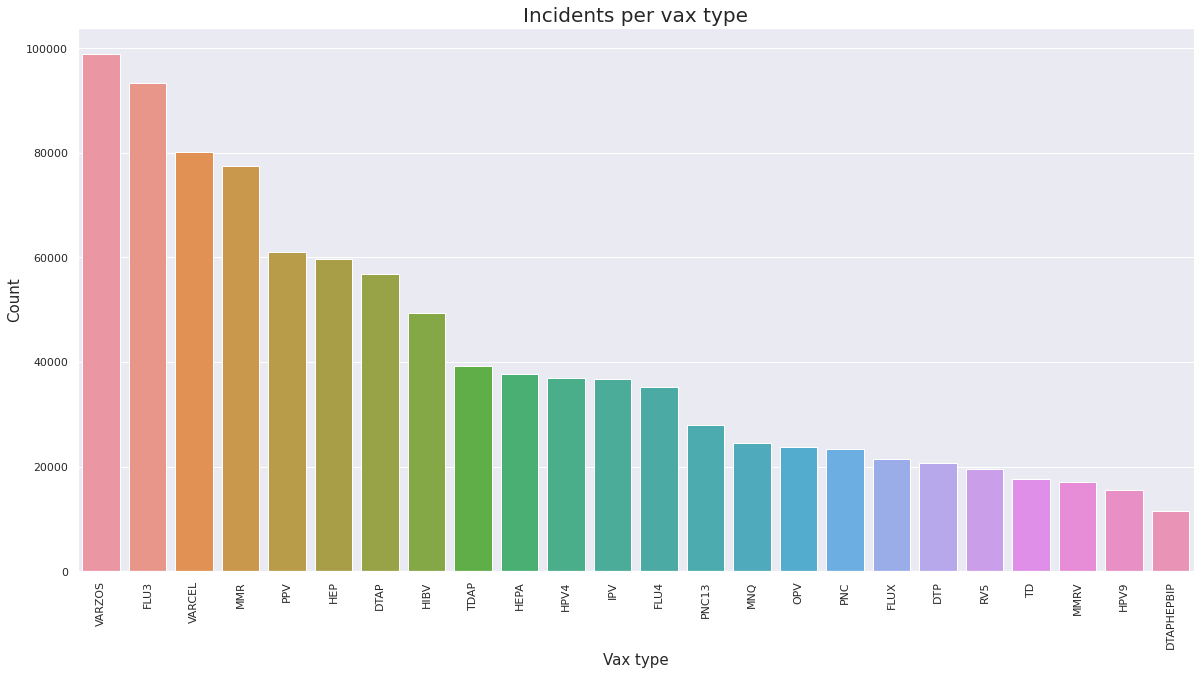

In [4]:
sns.set(palette = 'Blues_d')
plt.figure(figsize=(20, 10))
ax = sns.barplot(x = 'VAX_TYPE', y = 'Count', data = vaxcounts.to_pandas())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Vax type', fontsize=15)
plt.title('Incidents per vax type', fontsize=20)
plt.show()

Zůstalo nám tady pár typů vakcín, které stojí za prozkoumání.

In [5]:
vaxdesc = pl.read_excel('vax_type_description.xlsx').filter(pl.col('VAX_TYPE').is_in(vaxcounts['VAX_TYPE'].to_list())).join(vaxcounts, left_on = 'VAX_TYPE', right_on = 'VAX_TYPE')
#vaxdesc = vaxdesc[vaxdesc['VAX_TYPE'].isin(vaxcounts_forgraph['VAX_TYPE'].tolist())]
#vaxdesctable = vaxcounts_forgraph.merge(vaxdesc, left_on='VAX_TYPE', right_on='VAX_TYPE').rename(columns={'VAERS_ID':'COUNT'})
#print(tabulate(vaxdesc.limit(5).to_pandas(), headers='keys', tablefmt='plain'))

In [6]:
tab.tabulate(vaxdesc.to_pandas().head(10),
                   tablefmt='html',
                   headers='keys',
                   showindex=False
                   )

VAX_TYPE,DESCRIPTION,Count
VARZOS,Varicella-zoster vaccine,98940
FLU3,"Influenza virus vaccine, trivalent",93354
VARCEL,Varivax-varicella virus live,80189
MMR,"Measles, mumps and rubella virus vaccine, live",77536
PPV,"Pneumococcal vaccine, polyvalent",61006
HEP,Hepatitis B virus vaccine,59783
DTAP,Diphtheria and tetanus toxoids and acellular pertussis vaccine,56929
HIBV,Haemophilus B conjugate vaccine,49310
TDAP,"Tetanus toxoid, reduced diphtheria toxoid and acellular pertussis vaccine, adsorbed",39223
HEPA,Hepatitis A,37823


In [18]:
ndata = (
    bigdata
    .lazy()
    .filter(pl.col('VAX_TYPE').is_in(vaxcounts['VAX_TYPE'].to_list()))
    .groupby('VAX_TYPE')
    .agg(
        [(pl.col('VAERS_ID').count().alias('Count')),
         (pl.col('RECVDATE').min().alias('Min RECVDATE')),
         (pl.col('VAX_DATE').min().alias('Min VAX_DATE'))]
    )
    .sort(pl.col('Count'), reverse=True)
).select([
    pl.col('VAX_TYPE'),
    pl.col('Count'),
    pl.col('Min RECVDATE'),
    pl.col('Min VAX_DATE')
    ]).collect()

tab.tabulate(ndata.to_pandas().head(10),
                   tablefmt='html',
                   headers='keys',
                   showindex=False
                   )

#ndata = bigdata[bigdata['VAX_TYPE'].isin(vaxcounts_forgraph['VAX_TYPE'].tolist())]
#gndata = ndata.groupby('VAX_TYPE').agg(['count', 'min'])
#gndata.loc[:, [('VAERS_ID', 'count'), ('RECVDATE', 'min'), ('VAX_DATE', 'min')]].sort_values('VAX_TYPE')

VAX_TYPE,Count,Min RECVDATE,Min VAX_DATE
DTAP,56929,1992-04-07 00:00:00,1971-04-01 00:00:00
DTAPHEPBIP,11532,2003-02-12 00:00:00,1994-09-01 00:00:00
DTP,20793,1990-07-02 00:00:00,1960-03-07 00:00:00
FLU3,93354,1990-07-09 00:00:00,1933-10-06 00:00:00
FLU4,35251,2013-09-05 00:00:00,1940-04-22 00:00:00
FLUX,21551,1990-07-09 00:00:00,1944-12-02 00:00:00
HEP,59783,1990-07-09 00:00:00,1961-05-28 00:00:00
HEPA,37823,1995-04-24 00:00:00,1989-04-04 00:00:00
HIBV,49310,1990-07-09 00:00:00,1976-01-22 00:00:00
HPV4,37046,2006-07-14 00:00:00,1994-10-17 00:00:00


In [ ]:
#vaxesbytype = vaxes[['VAX_TYPE', 'VAX_NAME']].groupby('VAX_TYPE').agg(['VAX_NAME', ', '.join])
#vaxesbytype = vaxes[['VAX_TYPE', 'VAX_NAME']].groupby('VAX_TYPE')['VAX_NAME'].transform(lambda x : '|'.join(x)).reset_index()
#vaxesbytype.drop_duplicates(inplace=True)
#vaxesbytype
#vaxesbytype = vaxes[['VAX_TYPE', 'VAX_NAME', 'VAX_MANU']].sort_values(['VAX_TYPE', 'VAX_NAME', 'VAX_MANU']).drop_duplicates()
#vaxesbytype.to_excel('vaxesbytype.xlsx', index=False)


In [ ]:
#tady to pocitam z VAX dat, ale to podle myho pocita blbe, budou tam duplicity
disease_count = vaxes[['VAX_TYPE', 'VAERS_ID']].merge(disease_by_vax,
                                                        left_on='VAX_TYPE',
                                                        right_on='VAX_TYPE').groupby('DISEASE').agg('count').reset_index().sort_values('DISEASE')
disease_count_noc19 = disease_count[disease_count['DISEASE'] != 'Covid 19']

In [ ]:
# vezmu informace z bigdat.
# hm, mozna bych to mohl vzit i z VAX dat a vysledek by byl stejnej, jde o tu deduplikaci,
# protoze potrebuju jen ciste pocty IDcek v jednotlivych nemocech
disease_data = pd.merge( left=bigdata,
                    right=disease_by_vax,
                    left_on='VAX_TYPE',
                    right_on='VAX_TYPE')[['DISEASE', 'VAERS_ID']].drop_duplicates(keep='first')

In [ ]:
disease_count = disease_data.groupby('DISEASE').agg('count').reset_index()
disease_count_noc19 = disease_count[disease_count['DISEASE'] != 'Covid 19']

In [ ]:
# data pro graf
filtr = disease_count

In [ ]:
sns.set(palette = 'Blues_d')
plt.figure(figsize=(20, 10))
ax = sns.barplot(x = 'DISEASE', y = 'VAERS_ID', data = disease_count_noc19)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.show()

In [ ]:
disease_count_noc19[['DISEASE', 'VAERS_ID']].rename(columns={'VAERS_ID': 'Count'})